In [219]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import haversine_distances
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

In [220]:
# Loading telecom dataset
telecom_data = pd.read_csv('cellular_dataframe.csv')

# remove nan values in latitudes and longitudes in telecom_data
telecom_data = telecom_data[~np.isnan(telecom_data['Latitude'])]
telecom_data = telecom_data[~np.isnan(telecom_data['Longitude'])]
#remove nan values in PCell_Downlink_Num_RBs, PCell_Downlink_TB_Size, SCell_Downlink_TB_Size and datarate
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_TB_Size'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_Num_RBs'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_28'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_Downlink_RBs_MCS_31'])]
telecom_data = telecom_data[~np.isnan(telecom_data['PCell_RSRP_max'])]
telecom_data = telecom_data[~np.isnan(telecom_data['SCell_RSRP_max'])]
telecom_data = telecom_data[~np.isnan(telecom_data['datarate'])]
telecom_data['datarate'] = ((np.max(telecom_data['datarate'])-telecom_data['datarate'])*100)/(np.max(telecom_data['datarate'])-np.min(telecom_data['datarate']))
# # selecting a random 10000 rows from the dataset
# telecom_data = telecom_data.sample(n=20000, random_state=42)

#splitting the dataset into train and test sets
train_data, test_data = train_test_split(telecom_data, test_size=0.2, random_state=42)

telecom_data = train_data

print(telecom_data.shape)
print(test_data.shape)

# Extract relevant features and labels
features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
# # normalizing the labels using min-max normalization
# labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))

 
# Extract latitudes and longitudes
latitudes = telecom_data['Latitude'].values
longitudes = telecom_data['Longitude'].values

(3319, 159)
(664, 159)


In [221]:
# finding min and max values of labels
print(np.min(labels), np.max(labels))

0.0 100.0


In [222]:
# Calculate pairwise distances using Haversine formula
coordinates = np.column_stack((latitudes, longitudes))
dist_matrix = haversine_distances(np.radians(coordinates))

# Define distance threshold for edges
distance_threshold = 1  # For example, consider nodes within 1 km as neighbors

In [223]:

# Create adjacency matrix based on distance threshold
adj_matrix = (dist_matrix <= distance_threshold).astype(int)

# Convert adjacency matrix to edge indices
edge_indices = np.transpose(np.nonzero(adj_matrix))
edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()


In [224]:
# Split data into train and test sets
X_train, y_train = features,labels
y_train= y_train.reshape(-1,1)

In [225]:
X_train.shape

(3319, 8)

In [226]:
# Convert data to tensors
x = torch.FloatTensor(X_train)
y = torch.FloatTensor(y_train)

In [227]:
# Create a graph data object using torch_geometric
data = Data(x=x, edge_index=edge_indices, y=y)

In [228]:
from torch_geometric.nn import SAGEConv

class ComplexGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ComplexGNN, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)
        self.conv5 = SAGEConv(hidden_dim, hidden_dim)
        self.conv6 = SAGEConv(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv5(x, edge_index)
        x = torch.relu(x)
        x = self.conv6(x, edge_index)
        x = torch.relu(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x

In [229]:
# Define your loss function and optimizer
gnn_model = ComplexGNN(input_dim=features.shape[1], hidden_dim=16, output_dim=1)
# # loading a pytorch model from a saved state dict
# gnn_model.load_state_dict(torch.load('lat_long_node_GNN_rsrp.pth'))
loss_function = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)

# Create a DataLoader for batching your data
dataloader = DataLoader([data], batch_size=200)

In [231]:
# loading training and validation loss from a pickle file
import pickle
with open('lat_long_node_GNN_rsrp.pkl', 'rb') as f:
    training_acc, validation_acc = pickle.load(f)

In [139]:
# training_acc = []
# validation_acc = []

In [232]:
def get_validation(test_data):
    telecom_data = test_data
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    # # normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
     
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # For example, consider nodes within 10 km as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=664)
    # Evaluation on test set
    gnn_model.eval()
    with torch.no_grad():
        for batch_data in dataloader:
            #print(batch_data.x.shape, batch_data.edge_index.shape, batch_data.y.shape)
            output = gnn_model(batch_data.x, batch_data.edge_index)
            loss = loss_function(output, batch_data.y)
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Batch Loss: {(loss.item()):.4f}")
            return loss.item()

In [235]:
# Training loop
num_epochs = 2000

for epoch in range(num_epochs):
    #setting best validation loss to infinity
    best_val_loss = np.inf
    for batch_data in dataloader:
        optimizer.zero_grad()
        # print(batch_data.x.shape, batch_data.edge_index.shape, batch_data.y.shape)
        output = gnn_model(batch_data.x, batch_data.edge_index)
        loss = loss_function(output, batch_data.y)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Batch Loss: {(loss.item()):.4f}")
        val_loss = get_validation(test_data)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {(val_loss):.4f}")
        print("--------------------------------------------------")
        training_acc.append(loss.item())
        validation_acc.append(val_loss)
        # saving the model with best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(gnn_model.state_dict(), 'lat_long_node_GNN_rsrp_best.pth')

Epoch [1/2000], Batch Loss: 165.0932
Epoch [1/2000], Validation Loss: 201.7009
--------------------------------------------------
Epoch [2/2000], Batch Loss: 165.0756
Epoch [2/2000], Validation Loss: 201.6787
--------------------------------------------------
Epoch [3/2000], Batch Loss: 165.0584
Epoch [3/2000], Validation Loss: 201.6598
--------------------------------------------------
Epoch [4/2000], Batch Loss: 165.0413
Epoch [4/2000], Validation Loss: 201.6340
--------------------------------------------------
Epoch [5/2000], Batch Loss: 165.0239
Epoch [5/2000], Validation Loss: 201.6349
--------------------------------------------------
Epoch [6/2000], Batch Loss: 165.0054
Epoch [6/2000], Validation Loss: 201.6829
--------------------------------------------------
Epoch [7/2000], Batch Loss: 164.9860
Epoch [7/2000], Validation Loss: 201.7553
--------------------------------------------------
Epoch [8/2000], Batch Loss: 164.9671
Epoch [8/2000], Validation Loss: 201.8430
-----------

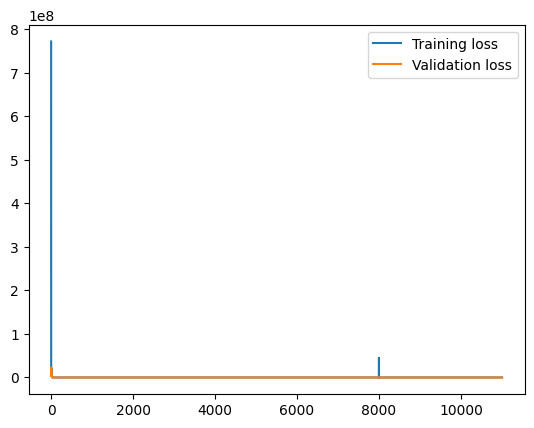

In [236]:
# plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_acc, label='Training loss')
plt.plot(validation_acc, label='Validation loss')
plt.legend()
plt.show()

In [237]:
print(min(validation_acc))
#122.72

65.55347442626953


In [238]:
len(validation_acc)

11005

In [239]:
# print last 10 validation losses
validation_acc[-10:]

[76.71598052978516,
 85.4377670288086,
 91.19566345214844,
 75.65624237060547,
 95.31307983398438,
 79.50267791748047,
 79.46087646484375,
 92.72312927246094,
 76.27410125732422,
 85.94194793701172]

In [257]:
# print last 100 validation losses
print(validation_acc[-100:])


[99.48250579833984, 99.30841827392578, 99.45175170898438, 99.2787094116211, 99.20259857177734, 99.26128387451172, 98.99451446533203, 99.0519027709961, 99.0507583618164, 98.85538482666016, 98.86589050292969, 98.78237915039062, 98.70154571533203, 98.80227661132812, 98.5480728149414, 98.51824188232422, 98.5300521850586, 98.33113861083984, 98.46385192871094, 98.23704528808594, 98.13346099853516, 98.3337631225586, 97.91302490234375, 98.15076446533203, 97.94328308105469, 97.83546447753906, 97.98936462402344, 97.45056915283203, 97.45499420166016, 97.2672119140625, 97.10594177246094, 97.3787612915039, 97.0092544555664, 97.12505340576172, 96.87834930419922, 96.83753204345703, 96.91868591308594, 96.495361328125, 96.54236602783203, 96.24102020263672, 96.02452087402344, 95.77027893066406, 94.97882843017578, 94.66944122314453, 94.01976776123047, 93.7532730102539, 93.25453186035156, 92.86546325683594, 92.37850952148438, 92.20219421386719, 92.01032257080078, 91.83782196044922, 91.68879699707031, 91.2

In [240]:
# saving the model
torch.save(gnn_model.state_dict(), 'lat_long_node_GNN_rsrp.pth')

In [241]:
# saving the validation loss and training loss as a pickle file
import pickle
with open('lat_long_node_GNN_rsrp.pkl', 'wb') as f:
    pickle.dump([training_acc, validation_acc], f)

In [242]:
def evaluate_model(telecom_data):
    # Extract relevant features and labels
    features = telecom_data[['PCell_Downlink_Num_RBs', 'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size','SCell_Downlink_Num_RBs','SCell_Downlink_RBs_MCS_28','SCell_Downlink_RBs_MCS_31','PCell_RSRP_max','SCell_RSRP_max']].values
    labels = telecom_data['datarate'].values  # Replace 'label' with your actual label column
    
    # # Normalizing the labels using min-max normalization
    # labels = ((np.max(labels)-labels)*100)/(np.max(labels)-np.min(labels))
    
    # Extract latitudes and longitudes
    latitudes = telecom_data['Latitude'].values
    longitudes = telecom_data['Longitude'].values
    
    # Calculate pairwise distances using Haversine formula
    coordinates = np.column_stack((latitudes, longitudes))
    dist_matrix = haversine_distances(np.radians(coordinates))
    
    # Define distance threshold for edges
    distance_threshold = 1  # Consider nodes within specified distance as neighbors
    
    # Create adjacency matrix based on distance threshold
    adj_matrix = (dist_matrix <= distance_threshold).astype(int)
    
    # Convert adjacency matrix to edge indices
    edge_indices = np.transpose(np.nonzero(adj_matrix))
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    loss_function = nn.MSELoss()
    
    X_train, y_train = features,labels
    y_train= y_train.reshape(-1,1)
    
    # Convert data to tensors
    x = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    
    # Create a graph data object using torch_geometric
    data = Data(x=x, edge_index=edge_indices, y=y)
    dataloader = DataLoader([data], batch_size=20)
    
    # Evaluation on test set
    gnn_model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch_data in dataloader:
            output = gnn_model(batch_data.x, batch_data.edge_index)
            
            true_labels.extend(batch_data.y.numpy())
            predicted_labels.extend(output.numpy())

    return true_labels, predicted_labels

In [243]:
a,b = evaluate_model(telecom_data=test_data)

In [244]:
print(a)

[array([68.69766], dtype=float32), array([64.0784], dtype=float32), array([48.409866], dtype=float32), array([68.25421], dtype=float32), array([85.84436], dtype=float32), array([52.105274], dtype=float32), array([52.844357], dtype=float32), array([49.14895], dtype=float32), array([73.464745], dtype=float32), array([48.409866], dtype=float32), array([66.7391], dtype=float32), array([81.705505], dtype=float32), array([35.10639], dtype=float32), array([41.75813], dtype=float32), array([49.888027], dtype=float32), array([73.68647], dtype=float32), array([30.302359], dtype=float32), array([65.076164], dtype=float32), array([61.3438], dtype=float32), array([92.0157], dtype=float32), array([28.824194], dtype=float32), array([30.6719], dtype=float32), array([60.604717], dtype=float32), array([57.278847], dtype=float32), array([77.75142], dtype=float32), array([42.866753], dtype=float32), array([74.092964], dtype=float32), array([90.35276], dtype=float32), array([60.235176], dtype=float32), arr

In [245]:
print(b)

[array([70.886566], dtype=float32), array([60.898125], dtype=float32), array([58.715534], dtype=float32), array([70.94542], dtype=float32), array([82.1514], dtype=float32), array([59.734543], dtype=float32), array([52.468582], dtype=float32), array([37.677986], dtype=float32), array([82.1514], dtype=float32), array([48.283768], dtype=float32), array([78.65723], dtype=float32), array([82.1514], dtype=float32), array([37.915565], dtype=float32), array([38.862343], dtype=float32), array([51.257027], dtype=float32), array([79.42464], dtype=float32), array([39.294167], dtype=float32), array([70.2468], dtype=float32), array([66.77785], dtype=float32), array([82.1514], dtype=float32), array([42.885628], dtype=float32), array([36.714943], dtype=float32), array([60.672466], dtype=float32), array([67.457245], dtype=float32), array([82.1514], dtype=float32), array([53.039932], dtype=float32), array([82.1514], dtype=float32), array([82.1514], dtype=float32), array([40.086296], dtype=float32), arra

In [246]:
print(len(b))

664


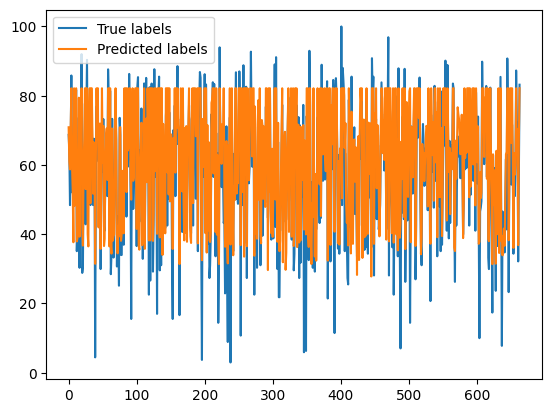

In [247]:
# plotting the graph for a and b
import matplotlib.pyplot as plt
plt.plot(a, label='True labels')
plt.plot(b, label='Predicted labels')
plt.legend()
plt.show()

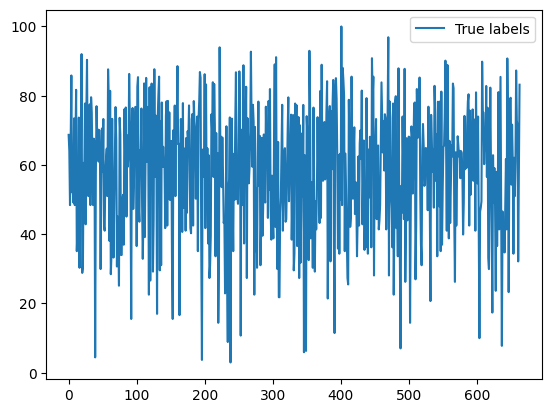

In [249]:
# displaying the true and predicted labels in different graphs
import matplotlib.pyplot as plt
plt.plot(a, label='True labels')
plt.legend()
plt.show()

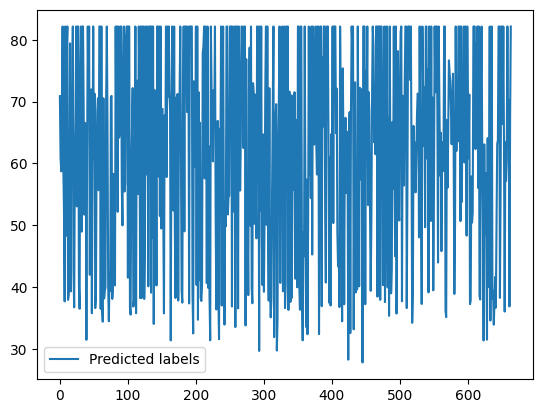

In [250]:
plt.plot(b, label='Predicted labels')
plt.legend()
plt.show()


In [251]:
# calculating the mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(a,b)

6.802608

In [252]:
# calculating the mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(a,b)

85.94195

In [253]:
# calculating the root mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(a,b, squared=False)

9.270488

In [254]:
# calculating the r2 score
from sklearn.metrics import r2_score
r2_score(a,b)

0.7535068022489532

In [255]:
# printing the mean absolute percentage error using sklearn
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(a,b)

0.224042